In [114]:
from core.repository import maria_home
import numpy as np
import pandas as pd
from core import cli

df = pd.read_sql("select * from index_chart where ticker = '1001'", maria_home())
df.index = pd.to_datetime(df["date"])
columns = {
    "종가": "idx",
    "거래대금": "amt"
}
df = df[columns.keys()]
df = df.rename(columns=columns)
df["ma100"] = df["idx"].rolling(100).mean()
df["ma200"] = df["idx"].rolling(200).mean()

df = df.resample("M").last()
df["idx_change"] = df["idx"].pct_change()
df = df.join(cli.from_bok())
df["rtn"] = df["idx_change"].shift(-1)
df = df.reindex(df["cli"].dropna().index)

df.loc[df["cli_change"] == np.nan, "port"] = np.nan
df.loc[df["cli_change"] >= 0, "port"] = df["rtn"]
df.loc[df["cli_change"] < 0, "port"] = -df["rtn"]
df

,idx,amt,ma100,ma200,idx_change,cli_pos,cli,cli_change,rtn,port
date,,,,,,,,,,
1990-02-28,861.59,328656000000,891.4489,903.61350,-0.038576,1990-01,100.5064,NaN,-0.024025,NaN
1990-03-31,840.89,277064000000,878.3981,899.14855,-0.024025,1990-02,100.4996,-0.000068,-0.181034,0.181034
1990-04-30,688.66,63703000000,851.6693,885.34235,-0.181034,1990-03,100.5666,0.000667,0.158700,0.158700
1990-05-31,797.95,305127000000,818.7734,862.22210,0.158700,1990-04,100.6346,0.000676,-0.114243,-0.114243
1990-06-30,706.79,74082000000,793.0965,842.48225,-0.114243,1990-05,100.6537,0.000190,-0.040196,-0.040196
...,...,...,...,...,...,...,...,...,...,...
2023-08-31,2556.27,11334960549622,2564.7146,2485.80935,-0.028987,2023-07,99.29905,0.002188,-0.035677,-0.035677
2023-09-30,2465.07,6761281210971,2567.1893,2496.28990,-0.035677,2023-08,99.48109,0.001833,-0.075892,-0.075892
2023-10-31,2277.99,8233073267951,2540.3713,2503.18640,-0.075892,2023-09,99.63481,0.001545,0.112950,0.112950


In [115]:
# 1억, 1억2천

years = len(df["cli_change"]) / 12


def _cagr(x):
    return (df[x]["rtn"] + 1).prod() ** (1 / years) - 1


pd.Series({
    "년도수": years,
    "CLI (+) 수익률": _cagr(df["cli_change"] >= 0),
    "CLI (-) 수익률": _cagr(df["cli_change"] < 0)
})

년도수            33.916667
CLI (+) 수익률     0.114888
CLI (-) 수익률    -0.072119
dtype: float64

33.69 years
코스피 지수 3.15770195863906
Long only 39.20300345161415
Long & Short 136.548942418374


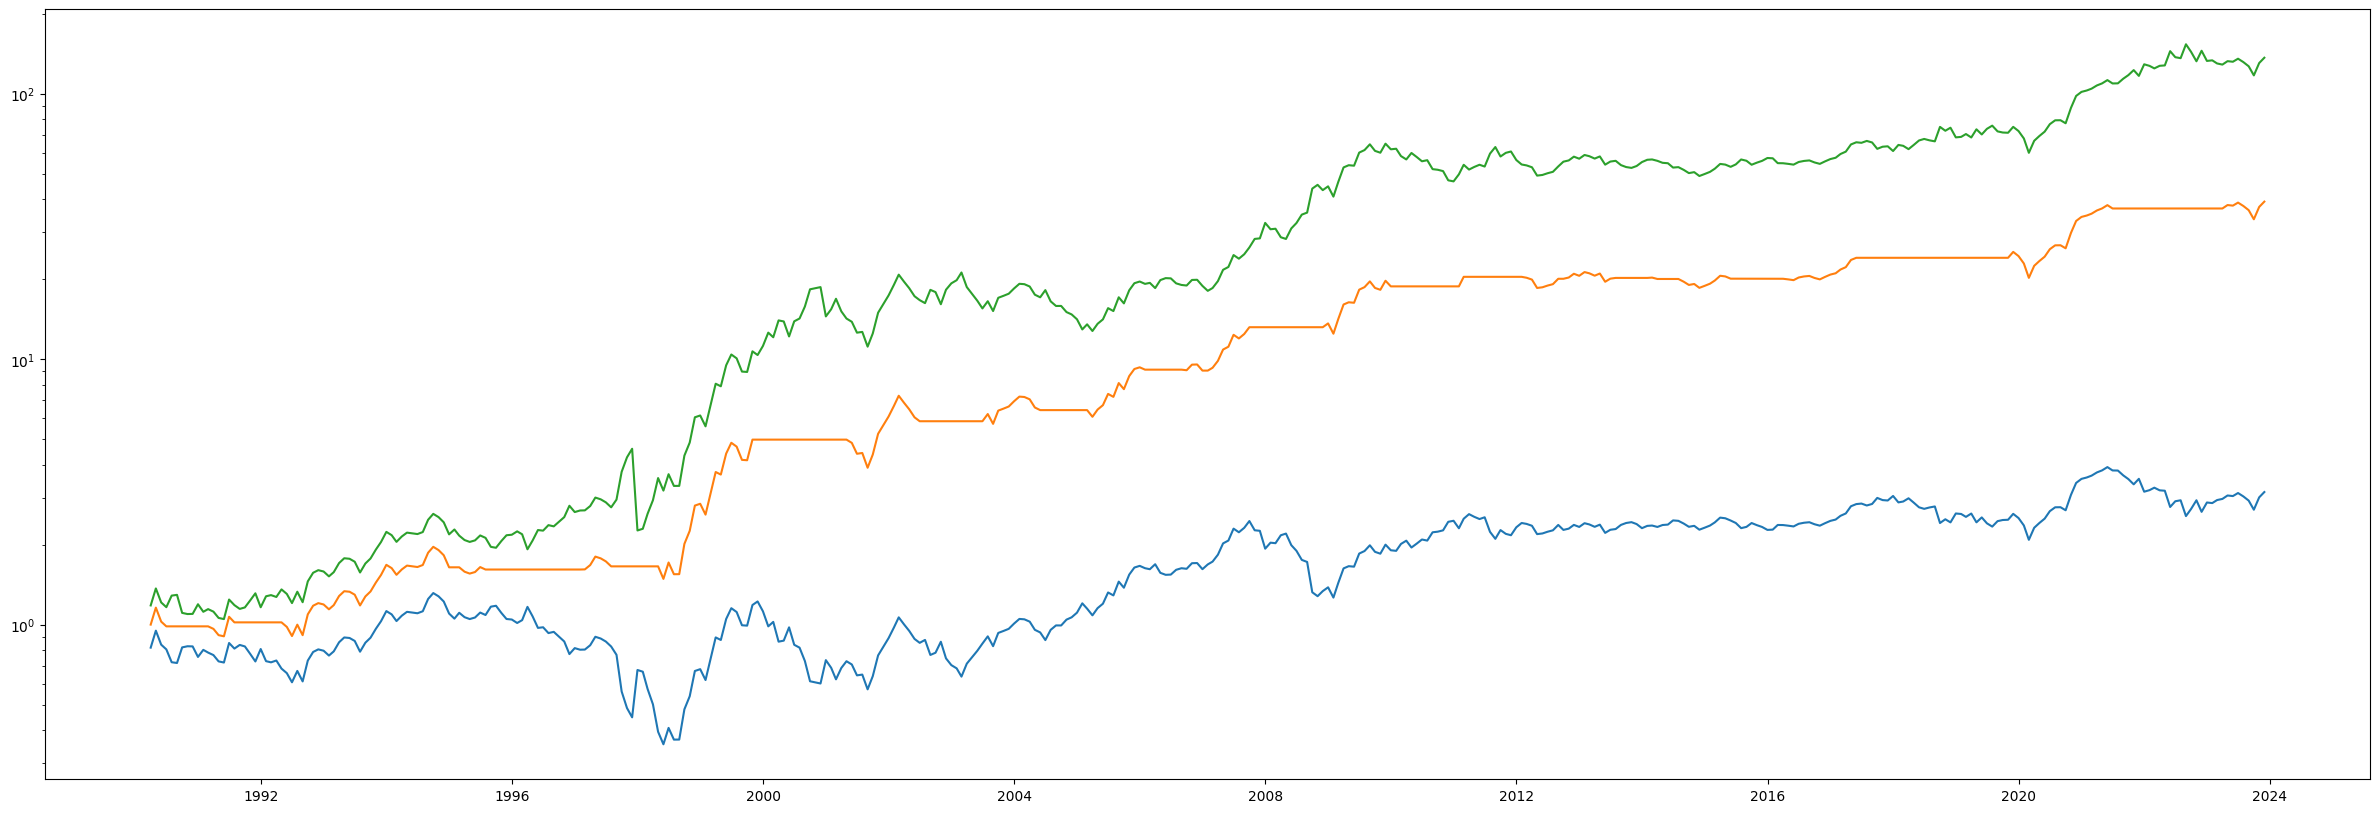

In [116]:
import matplotlib.pyplot as plt

df = df.dropna()

print(round((df.index.max() - df.index.min()).days / 365, 2), "years")
print("코스피 지수", (df["rtn"] + 1).prod())
print("Long only", (df[df["cli_change"] > 0]["rtn"] + 1).prod())
print("Long & Short", (df["port"] + 1).prod())

plt.figure(figsize=(30, 10))
plt.plot((df["rtn"] + 1).cumprod(), label="idx")
plt.plot((df[df["cli_change"] > 0]["rtn"].reindex(df.index).fillna(0) + 1).cumprod())
plt.plot((df["port"] + 1).cumprod())
plt.yscale('log')